In [1]:
import os
import glob
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from bregman_kit.BregmanClustering import BregmanHardClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from bregman_kit.utils import squared_euclidean, kl_divergence, itakura_saito, plot_clusters, plot_clusters_3d
from sklearn.metrics import adjusted_rand_score, mutual_info_score
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.replace('\n', ' ').replace('\r', ' ')
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
        
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    
    tokens = [word for word in tokens if not word.isdigit()]
    tokens = [word for word in tokens if len(word) > 1]
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ikbal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ikbal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Ikbal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ikbal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def read_texts_from_folder(folder_path):
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Folder not found: {folder_path}")
    
    all_texts = []
    all_filenames = []
    
    txt_files = glob.glob(os.path.join(folder_path, "**", "*.txt"), recursive=True)
    
    for file_path in txt_files:
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
                all_texts.append(preprocess_text(text))
                all_filenames.append(os.path.basename(file_path))
        except UnicodeDecodeError:
            try:
                with open(file_path, 'r', encoding='latin-1') as file:
                    text = file.read()
                    all_texts.append(text)
                    all_filenames.append(os.path.basename(file_path))
            except Exception as e:
                print(f"Error reading file: {file_path} with both encodings. Error: {e}")
    return all_texts, all_filenames

In [4]:
categories = ["business", "entertainment", "politics", "sport", "tech"]
texts = []
labels = []

for i, cat in enumerate(categories):
    t, _ = read_texts_from_folder(f"News Articles/{cat}/")
    texts += t
    labels += [i] * len(t)
    
data = pd.DataFrame({
    'text' : texts,
    'label' : labels
})

data = data.sample(frac=1, random_state=42)

texts = data.text.to_numpy()
labels = data.label.to_numpy()

In [5]:
def create_tfidf_vectors(texts, max_features=None, min_df=.1, max_df=.85, ngram_range=(1, 1)):
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        min_df=min_df,
        max_df=max_df,
        ngram_range=ngram_range
    )
    tfidf_matrix = vectorizer.fit_transform(texts)

    return tfidf_matrix, vectorizer

In [6]:
tfidf_matrix, vectorizer = create_tfidf_vectors(texts)
tfidf = tfidf_matrix.toarray()

Squared Euclidean
Silhouette Score: 0.04514586664696469
Adjusted Rand Score: 0.4887570874702466
Mutual Inforamtion Score: 0.8468344042869949
Davis-Boildin Index: 4.6077540970445785


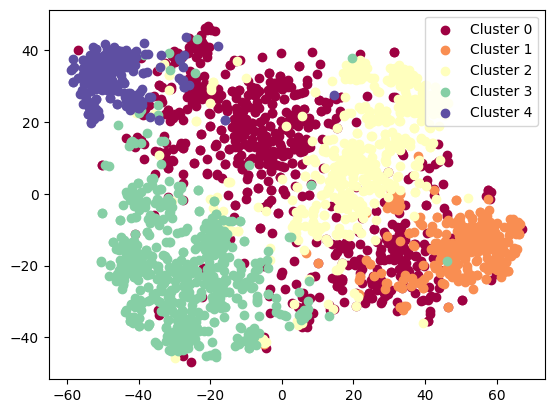

In [7]:
#Squared Eucliedan (classical kmeans)
model = BregmanHardClustering(5, squared_euclidean, random_state=42)
model.fit(tfidf)
clusters = model.predict(tfidf)
print("Squared Euclidean")
try:
    print(f"Silhouette Score: {silhouette_score(tfidf, clusters)}")
    print(f"Adjusted Rand Score: {adjusted_rand_score(labels, clusters)}")
    print(f"Mutual Inforamtion Score: {mutual_info_score(labels, clusters)}")
    print(f"Davis-Boildin Index: {davies_bouldin_score(tfidf, clusters)}")
except:
    print("Плохая кластеризация")

reduced = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(tfidf)

plot_clusters(reduced, clusters)

KL-divergence
Silhouette Score: 0.014997960033891972
Adjusted Rand Score: 0.7975459224558722
Mutual Inforamtion Score: 1.217351906693596
Davis-Boildin Index: 4.556585739937459


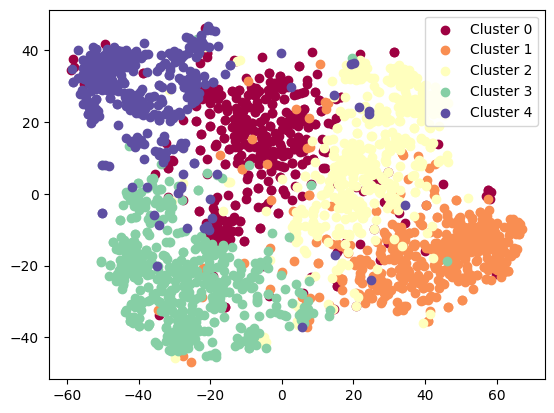

In [8]:
#KL-divergence
tfidf_smoothed = tfidf + 1e-8
tfidf_smoothed = np.array([v / np.sum(v) for v in tfidf_smoothed])

model = BregmanHardClustering(5, kl_divergence, random_state=42)
model.fit(tfidf_smoothed)
clusters = model.predict(tfidf_smoothed)
print("KL-divergence")
try:
    print(f"Silhouette Score: {silhouette_score(tfidf_smoothed, clusters)}")
    print(f"Adjusted Rand Score: {adjusted_rand_score(labels, clusters)}")
    print(f"Mutual Inforamtion Score: {mutual_info_score(labels, clusters)}")
    print(f"Davis-Boildin Index: {davies_bouldin_score(tfidf_smoothed, clusters)}")
except:
    print("Плохая кластеризация")

reduced = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(tfidf)

plot_clusters(reduced, clusters)

Itakura-Saito
Silhouette Score: 0.028701339908480502
Adjusted Rand Score: 0.6227333332655719
Mutual Inforamtion Score: 0.9606572755025093
Davis-Boildin Index: 5.329624146480288


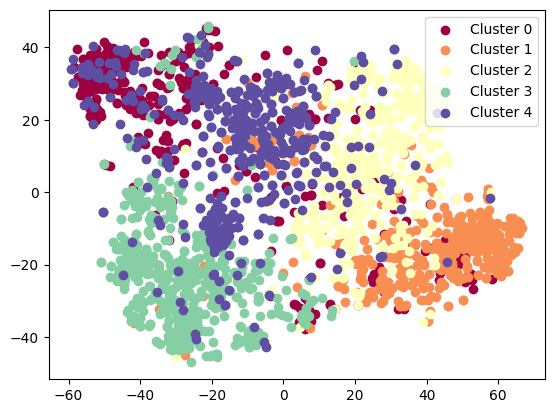

In [9]:
#Itakura-Saito
tfidf_smoothed = tfidf + 1e-8
tfidf_smoothed = np.array([v / np.linalg.norm(v) for v in tfidf_smoothed])

model = BregmanHardClustering(5, itakura_saito, random_state=42)
model.fit(tfidf_smoothed)
clusters = model.predict(tfidf_smoothed)
print("Itakura-Saito")
try:
    print(f"Silhouette Score: {silhouette_score(tfidf_smoothed, clusters)}")
    print(f"Adjusted Rand Score: {adjusted_rand_score(labels, clusters)}")
    print(f"Mutual Inforamtion Score: {mutual_info_score(labels, clusters)}")
    print(f"Davis-Boildin Index: {davies_bouldin_score(tfidf_smoothed, clusters)}")
except:
    print("Плохая кластеризация")

reduced = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(tfidf_smoothed)

plot_clusters(reduced, clusters)